In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx

In [2]:
from featureExtraction import featureExtraction

In [3]:
def loadImages(img_dir):
    img_names = os.listdir(img_dir)
    img_list = []
    # Load images
    for img_name in img_names:
        img = cv.imread(img_dir + img_name)
        img_list.append(img)

    return img_list

    

In [10]:
img_dir = "./data/setSmall/"
img_list = loadImages(img_dir)


In [11]:
fe = featureExtraction(img_list,method="FLANN")

In [12]:
fe.run()

Extracting SIFT features...
Generating matches...
Processing matches...
Computing homographies...
Computing adjacency matrix...


#### Visualizing the network

In [20]:
def display_network(adjacency_matrix):
    G = nx.Graph(adjacency_matrix)
    nx.draw(G, with_labels=True, font_weight='bold')
    plt.show()

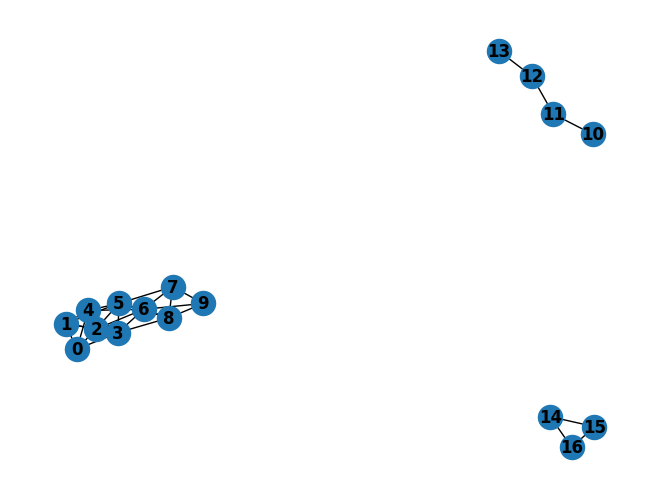

In [35]:
display_network(fe.adjacency_matrix)